#Синхронизация по движению точек поз

https://www.agisoft.com/downloads/installer/

In [ ]:
VIBE

In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
from ultralytics import YOLO
import mediapipe as mp
from tqdm import tqdm

In [ ]:
!pip install ultralytics

In [ ]:
!pip install mediapipe

In [ ]:
#@title Сохранение кадров видео камеры 1 с 223 секунды по 261 секунду (6694 - 7864 кадр)
# Путь к видеофайлу
video_path = '/content/drive/MyDrive/video/cam1.mp4'
# Путь для сохранения изображений поз
pose_patch = '/content/drive/MyDrive/image/pose/cam1/13'

# Создание директории для сохранения изображений поз
os.makedirs(pose_patch, exist_ok=True)

# Инициализация YOLO
yolo_model = YOLO('yolov8n.pt')  # Можно использовать другую предобученную модель

# Инициализация MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, enable_segmentation=False)

# Открытие видеофайла
cap = cv2.VideoCapture(video_path)

# Получение информации о видео
fps = cap.get(cv2.CAP_PROP_FPS)  # Количество кадров в секунду
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Общее количество кадров

# Временные метки (в секундах)
start_time = 223  # Начало извлечения кадров
end_time = 261    # Конец извлечения кадров

# Преобразование времени в номера кадров
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Проверка корректности временных меток
if start_frame >= total_frames or end_frame > total_frames or start_frame >= end_frame:
    print("Ошибка: некорректные временные метки.")
    cap.release()
    exit()

# Список для хранения данных о позах и номерах кадров
pose_data = []

# Установка начальной позиции видео
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Переменная для отслеживания текущего номера кадра
current_frame = start_frame

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or current_frame >= end_frame:
        break

    # Текущий номер кадра
    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1

    # Обнаружение объектов с помощью YOLO
    results = yolo_model(frame)
    boxes = results[0].boxes

    for box in boxes:
        cls = int(box.cls[0])
        if cls == 0:  # Класс 0 - человек
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Координаты рамки
            confidence = float(box.conf[0])  # Уверенность модели

            # Обрезка кадра по рамке
            cropped_frame = frame[y1:y2, x1:x2]

            # Детекция позы на обрезанном кадре
            results_pose = pose.process(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))

            if results_pose.pose_landmarks:
                landmarks = results_pose.pose_landmarks.landmark

                # Сохранение координат позы и номера кадра
                pose_row = [current_frame]  # Добавляем номер кадра в начало строки
                for idx, landmark in enumerate(landmarks):
                    pose_row.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])

                # Сохранение данных о позе в список
                pose_data.append(pose_row)

                # Рисование скелета на обрезанном кадре
                annotated_image = cropped_frame.copy()
                mp_drawing = mp.solutions.drawing_utils
                mp_drawing.draw_landmarks(
                    annotated_image,
                    results_pose.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS
                )

                # Сохранение изображения позы с номером кадра в названии
                image_filename = os.path.join(pose_patch, f'pose_frame_{current_frame}.jpg')
                cv2.imwrite(image_filename, annotated_image)

    # Увеличиваем счетчик кадров
    current_frame += 1

cap.release()

# Создание датафрейма с координатами поз и номерами кадров
columns = ['frame_number']  # Первый столбец — номер кадра
for i in range(len(mp_pose.PoseLandmark)):
    columns.extend([f'x_{i}', f'y_{i}', f'z_{i}', f'visibility_{i}'])

df_pose = pd.DataFrame(pose_data, columns=columns)

# Сохранение датафрейма в CSV-файл
csv_filename = os.path.join(pose_patch, 'pose_data.csv')
df_pose.to_csv(csv_filename, index=False)

print(f"Данные о позах сохранены в {csv_filename}")

In [ ]:
#@title Видео со 2- камеры сохранялось с 260 по 298 секунду (7747 - 8879 кадр)

In [ ]:
#Сохранение данных о точках поз
# Путь к видеофайлу
video_path = '/content/drive/MyDrive/video/cam1.mp4'
# Путь для сохранения данных (без сохранения изображений)
pose_patch = '/content/drive/MyDrive/image/pose/cam1/14'

# Создание директории для сохранения данных
os.makedirs(pose_patch, exist_ok=True)

# Инициализация YOLO
yolo_model = YOLO('yolov8n.pt')  # Можно использовать другую предобученную модель

# Инициализация MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, enable_segmentation=False)

# Открытие видеофайла
cap = cv2.VideoCapture(video_path)

# Получение информации о видео
fps = cap.get(cv2.CAP_PROP_FPS)  # Количество кадров в секунду
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Общее количество кадров

# Временные метки (в секундах)
start_time = 223  # Начало извлечения кадров
end_time = 261    # Конец извлечения кадров

# Преобразование времени в номера кадров
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Проверка корректности временных меток
if start_frame >= total_frames or end_frame > total_frames or start_frame >= end_frame:
    print("Ошибка: некорректные временные метки.")
    cap.release()
    exit()

# Список для хранения данных о позах и номерах кадров
pose_data = []

# Установка начальной позиции видео
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Переменная для отслеживания текущего номера кадра
current_frame = start_frame

# Создаем tqdm для отображения прогресса
progress_bar = tqdm(total=end_frame - start_frame, desc="Обработка", unit="frame",
                    bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or current_frame >= end_frame:
        break

    # Текущий номер кадра
    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1

    # Обнаружение объектов с помощью YOLO (отключаем логи с verbose=False)
    results = yolo_model(frame, verbose=False)
    boxes = results[0].boxes

    for box in boxes:
        cls = int(box.cls[0])
        if cls == 0:  # Класс 0 - человек
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Координаты рамки
            confidence = float(box.conf[0])  # Уверенность модели

            # Обрезка кадра по рамке
            cropped_frame = frame[y1:y2, x1:x2]

            # Детекция позы на обрезанном кадре
            results_pose = pose.process(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))

            if results_pose.pose_landmarks:
                landmarks = results_pose.pose_landmarks.landmark

                # Сохранение координат позы и номера кадра
                pose_row = [current_frame]  # Добавляем номер кадра в начало строки
                for idx, landmark in enumerate(landmarks):
                    pose_row.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])

                # Сохранение данных о позе в список
                pose_data.append(pose_row)

    # Обновление прогресс-бара
    progress_bar.update(1)

# Закрытие прогресс-бара
progress_bar.close()

cap.release()

# Создание датафрейма с координатами поз и номерами кадров
columns = ['frame_number']  # Первый столбец — номер кадра
for i in range(len(mp_pose.PoseLandmark)):
    columns.extend([f'x_{i}', f'y_{i}', f'z_{i}', f'visibility_{i}'])

df_pose = pd.DataFrame(pose_data, columns=columns)

# Сохранение датафрейма в CSV-файл
csv_filename = os.path.join(pose_patch, 'pose_data.csv')
df_pose.to_csv(csv_filename, index=False)

print(f"Данные о позах сохранены в {csv_filename}")

In [ ]:
# Функция для вычисления модуля движения с фильтрацией по visibility
def calculate_movement(df, visibility_threshold=0.5):
    # Список всех столбцов с координатами и видимостью
    landmark_columns = [f'x_{i}' for i in range(33)] + [f'y_{i}' for i in range(33)] + [f'z_{i}' for i in range(33)]
    visibility_columns = [f'visibility_{i}' for i in range(33)]

    # Создаем DataFrame для хранения изменений между кадрами
    delta_df = df[landmark_columns].diff()  # Разница между соседними кадрами

    # Добавление столбцов с модулем движения для каждой точки
    for i in range(33):
        # Проверяем видимость точки
        visibility = df[f'visibility_{i}']
        delta_x = delta_df[f'x_{i}']
        delta_y = delta_df[f'y_{i}']
        delta_z = delta_df[f'z_{i}']

        # Вычисляем движение только для точек с visibility >= threshold
        movement = np.where(visibility >= visibility_threshold,
                            np.sqrt(delta_x**2 + delta_y**2 + delta_z**2),
                            np.nan)  # Если visibility < threshold, ставим NaN

        delta_df[f'movement_{i}'] = movement

    # Удаление NaN-значений (первый кадр не имеет предшествующего)
    delta_df.dropna(inplace=True)

    return delta_df

# Загрузка данных
df_1 = pd.read_csv('/content/drive/MyDrive/image/pose/cam1/14/pose_data.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/image/pose/cam2/12/pose_data.csv')

# Вычисление модуля движения для каждого датафрейма с фильтрацией по visibility
delta_df_1 = calculate_movement(df_1, visibility_threshold=0.5)
delta_df_2 = calculate_movement(df_2, visibility_threshold=0.5)

In [ ]:
df_1

,frame_number,x_0,y_0,z_0,visibility_0,x_1,y_1,z_1,visibility_1,x_2,...,z_30,visibility_30,x_31,y_31,z_31,visibility_31,x_32,y_32,z_32,visibility_32
0,6694,0.336088,0.072868,-1.624680,0.999826,0.419578,0.051857,-1.618992,0.999842,0.451725,...,0.742203,0.919458,0.312464,0.980416,-0.713683,0.992135,0.071269,0.950422,0.299120,0.948804
1,6695,0.343046,0.073446,-1.573985,0.999750,0.420827,0.053315,-1.578832,0.999779,0.453518,...,0.146122,0.921164,0.246464,1.017296,-0.887683,0.992004,0.077442,0.956484,-0.220709,0.948462
2,6696,0.366168,0.074370,-1.568759,0.999727,0.439230,0.055464,-1.576573,0.999760,0.468986,...,0.023881,0.924778,0.234815,1.025254,-0.944502,0.992083,0.079082,0.957535,-0.328829,0.949683
3,6697,0.388168,0.074717,-1.556691,0.999656,0.460569,0.055817,-1.571858,0.999706,0.492170,...,0.091664,0.929148,0.236059,1.031868,-0.958321,0.992494,0.087696,0.962636,-0.248227,0.951965
4,6698,0.404531,0.074582,-1.542556,0.999582,0.473432,0.056238,-1.563843,0.999647,0.504665,...,0.167077,0.932870,0.255207,1.034856,-0.942624,0.992872,0.085675,0.956887,-0.178178,0.954008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,7830,0.127708,0.093427,-1.568059,0.998878,0.176797,0.071413,-1.561825,0.998140,0.198346,...,1.605244,0.716689,0.333859,0.997754,-0.369497,0.901526,0.042335,0.952995,1.094265,0.725959
1146,7831,0.120426,0.096536,-1.625210,0.998907,0.169577,0.074824,-1.620683,0.998224,0.193883,...,1.839246,0.701329,0.335074,0.990358,-0.542149,0.901729,0.061486,0.947436,1.387696,0.709115
1147,7832,0.106024,0.098569,-1.562175,0.998831,0.153651,0.076649,-1.547447,0.998181,0.176240,...,1.703037,0.695656,0.334837,0.987022,-0.409787,0.902557,0.062192,0.945935,1.263679,0.703165
1148,7833,0.096109,0.101181,-1.529050,0.998802,0.144869,0.079200,-1.527221,0.998188,0.167254,...,1.446944,0.689875,0.295580,0.984186,-0.464870,0.901803,0.049803,0.946310,0.982137,0.697462


In [ ]:
df_2

,frame_number,x_0,y_0,z_0,visibility_0,x_1,y_1,z_1,visibility_1,x_2,...,z_30,visibility_30,x_31,y_31,z_31,visibility_31,x_32,y_32,z_32,visibility_32
0,7747,0.459909,0.095416,0.761941,0.997931,0.425683,0.080912,0.576573,0.997854,0.403291,...,1.106006,0.716668,0.115403,0.920639,0.695336,0.775800,0.835422,0.915099,1.026058,0.424529
1,7748,0.476709,0.100834,0.885219,0.997614,0.445794,0.085187,0.692682,0.997322,0.420873,...,1.184129,0.726870,0.115980,0.917924,0.881045,0.766675,0.758297,0.918107,1.052304,0.424993
2,7749,0.485173,0.106313,0.856490,0.997396,0.456394,0.091118,0.670841,0.997010,0.431713,...,1.168696,0.734959,0.113145,0.920126,0.826742,0.764276,0.767673,0.915476,1.038581,0.427698
3,7750,0.481230,0.107561,0.745219,0.997385,0.455994,0.091845,0.547875,0.997000,0.433481,...,1.148912,0.743768,0.079911,0.924159,0.815724,0.765523,0.781450,0.921417,1.023872,0.434775
4,7751,0.474054,0.112195,0.693164,0.997407,0.451400,0.095640,0.484554,0.997004,0.431673,...,1.247880,0.749505,0.049747,0.922825,0.946873,0.760458,0.717838,0.934754,1.130239,0.435213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,8875,0.500896,0.103909,0.473501,0.999219,0.466910,0.087193,0.301413,0.999179,0.442445,...,0.957324,0.898215,0.254212,0.926382,0.836105,0.872006,0.859240,0.922618,0.837389,0.776584
1176,8876,0.494955,0.107667,0.485784,0.999214,0.461395,0.090169,0.319467,0.999188,0.437841,...,0.889999,0.903316,0.242139,0.927677,0.838356,0.877813,0.852371,0.923286,0.773928,0.789062
1177,8877,0.485429,0.108238,0.570115,0.999237,0.452460,0.090835,0.399479,0.999220,0.429245,...,0.866989,0.908650,0.264475,0.928219,0.841886,0.882939,0.881460,0.928546,0.720734,0.800102
1178,8878,0.479124,0.109987,0.563460,0.999162,0.445821,0.092705,0.393036,0.999159,0.423295,...,0.772945,0.910729,0.270713,0.928533,0.795165,0.879876,0.881175,0.932362,0.609498,0.806449


In [ ]:
# Индексы точек для рук, ног и туловища (11-32)
body_indices = list(range(11, 33))

# Суммарное движение для точек с 11 по 32
delta_df_1['body_movement'] = delta_df_1[[f'movement_{i}' for i in body_indices]].sum(axis=1)
delta_df_2['body_movement'] = delta_df_2[[f'movement_{i}' for i in body_indices]].sum(axis=1)

In [ ]:
# Вычисление корреляции с запаздыванием
movement_1 = delta_df_1['body_movement'].values
movement_2 = delta_df_2['body_movement'].values

# Убедитесь, что массивы имеют одинаковую длину
min_length = min(len(movement_1), len(movement_2))
movement_1 = movement_1[:min_length]
movement_2 = movement_2[:min_length]

# Вычисление корреляции
correlation = np.correlate(movement_1, movement_2, mode='full')

# Нахождение позиции максимальной корреляции
lag = np.argmax(correlation) - (len(movement_1) - 1)

print(f"Сдвиг кадров: {lag} кадров")

Сдвиг кадров: -25 кадров


# Пример:
7747 - 6694 = 1053 кадров 1-й сдвиг
1053 - 25 (второй сдви) = 1032 суммарный сдвиг

Пример: 7950 (кадр 2-й камеры) - 1032 = 6918 (кадр 1-й камеры)

7950 (кадр 2-й камеры)

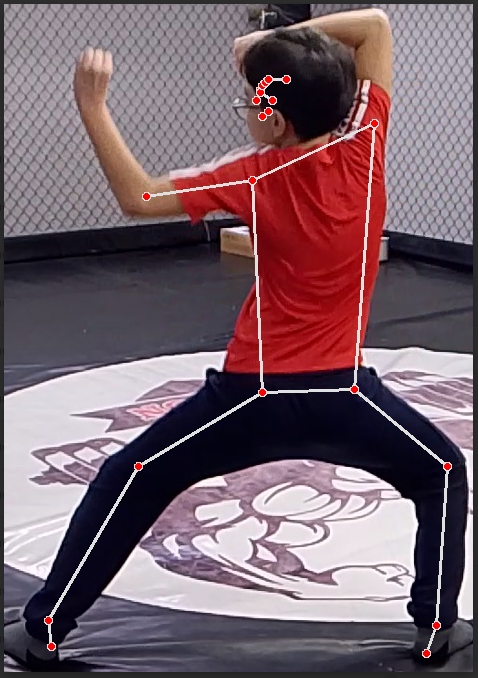

6918 (кадр 1-й камеры)

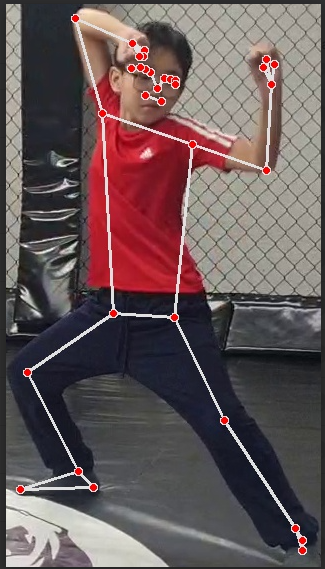

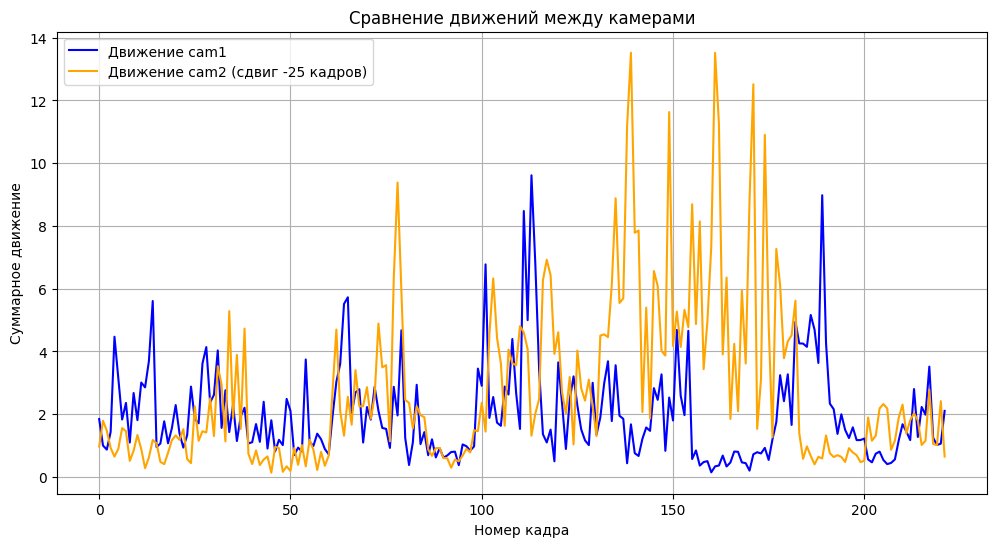

In [ ]:
import matplotlib.pyplot as plt

# Выравнивание данных по найденному сдвигу
if lag > 0:
    aligned_movement_2 = np.pad(movement_2, (lag, 0))[:len(movement_1)]
elif lag < 0:
    aligned_movement_2 = np.pad(movement_2, (0, -lag))[:len(movement_1)]
else:
    aligned_movement_2 = movement_2

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(movement_1, label='Движение cam1', color='blue')
plt.plot(aligned_movement_2, label=f'Движение cam2 (сдвиг {lag} кадров)', color='orange')
plt.title('Сравнение движений между камерами')
plt.xlabel('Номер кадра')
plt.ylabel('Суммарное движение')
plt.legend()
plt.grid(True)
plt.show()